In [159]:
#-----------------
# Standard imports
#-----------------
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
from sklearn.decomposition import PCA # for PCA for normalization
from scipy.spatial import distance_matrix

from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from sklearn.manifold import MDS # for MDS
import pandas as pd # for loading in colors csv
from scipy.spatial import ConvexHull # for convex hull
import seaborn as sns # for plotting

#---------------------------
# The ECT packages we'll use
#---------------------------
from ect import ECT, EmbeddedGraph # for calculating ECTs

In [131]:
def normalize(shape):
    """
    input: ordered coordinates of a 2D closed contour
    output: 2D array, coordinates origin centered on centroid and longest radius = 1
    """
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of leaf

    # return leaf normalized by longest axis to 1, zero centered
    return pca_scores/(np.max(pca_scores[:,0])-np.min(pca_scores[:,0]))

In [132]:
def get_ect(normal_sh, dir_num, thresh_num, global_bound_radius):
    """
    inputs: ordered coordinates of a normalized 2D closed contour, longest diameter = 1
    dir_num = number of directional axes
    thresh_num = number of thresholds
    global_bound_radius = half of the longest normalized diameter
    output: ECT as 2D array
    """
    G = EmbeddedGraph() # initiate an embedded graph

    valuesX = normal_sh[:,0] # isolate x vals
    valuesY = normal_sh[:,1] # isolate y vals
    for i in range(np.shape(normal_sh)[0]): # create nodes
        G.add_node(i,valuesX[i],valuesY[i])
    for i in range(np.shape(normal_sh)[0]-1): # create edges
        G.add_edge(i, i+1)
    G.add_edge(0,np.shape(normal_sh)[0]-1) # add final edge between start and end

    myect = ECT(num_dirs = dir_num, num_thresh=thresh_num) # intiate ECT
    myect.set_bounding_radius(global_bound_radius) # set bounding radius
    myect.calculateECT(G) # calculate ECT on embedded graph

    return myect.get_ECT() # retrieve ECT, 2D array, [axes, thresh]

In [133]:
def ect_diff(ect1, ect2,dir_num):
    """
    inputs: two, 2D arrays of ECTs and number of directional axes
    output: the minimum sum diff between the two ECT arrays across different orientations
    """
    diffs = [] # store differences 
    for i in range(dir_num): # for the number of directional axes
        roll_ect = np.roll(ect1,i,axis=0) # roll the array by 1 along directional axes
        diff_ect = np.abs(ect2 - roll_ect) # difference between the two arrays
        diffs.append(np.sum(diff_ect)) # store the sum of the differences
    return np.min(diffs) # return minimum difference

In [134]:
def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [138]:
datasets = ["Transect/Batch_1_W", "Transect/Batch_2_B"]

file_names = [] # store file names
dataset = [] # store dataset
solidity = [] # store solidity values
lw_ratio = [] # store length-to-width ratio

for i in datasets: # for each dataset

    data_dir = "./2017_leaves/"+i+"/" # set data directory
    files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
    #file_names.remove('.DS_Store') # remove .DS_Store file
    files.sort() # sort the list of file names

    for j in range(len(files)): # for each file
        
        file_names.append("./2017_leaves/"+i+"/"+files[j]) # store file names
        dataset.append(i) # store datasets
        
        # calculate solidity
        curr_lf = np.load("./2017_leaves/"+i+"/"+files[j]) # load current leaf
        hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
        vertices = hull.vertices # isolate vertex indices of convex hull
        area = poly_area(curr_lf[:,0], curr_lf[:,1]) # calculate area
        convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
        solidity.append( area / convex_area ) # calculate solidity and store
        
        # calculate length-to-width ratio
        pca = PCA(n_components=2) # initiate PCA
        pca.fit_transform(curr_lf) # fit PCA to leaf data to find longest axis
        pca_scores = pca.transform(curr_lf) # retrieve PCA scores of leaf
        length = np.max(pca_scores[:,0])-np.min(pca_scores[:,0]) # get length
        width = np.max(pca_scores[:,1])-np.min(pca_scores[:,1]) # get width
        lw_ratio.append(length/width) # store length-to-width ratio


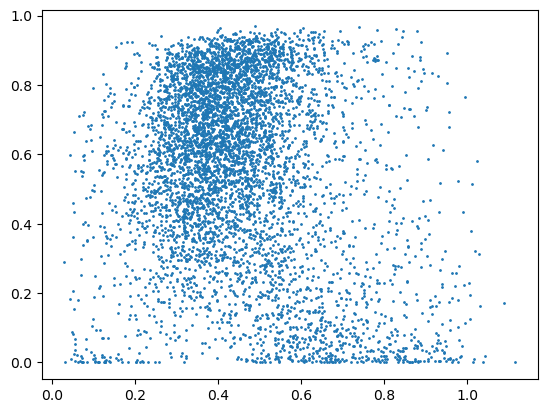

In [171]:
plt.scatter(1/(np.array(lw_ratio)), np.array(solidity)**8, s=1)

# Calculate ECTs for each leaf

In [149]:
num_dir=5 # set number of directional axes
num_thresh=5 # set number of thresholds each axis
rad = 0.5 # set the radius

# create array to store ECT outputs
# number of ECTs x num directional axes x number of thresholds
ect_arr = np.zeros((len(file_names),num_dir,num_thresh))

for i in range(len(file_names)): # for each leaf
    if i%100==0: # print if divisible by 25
        print(i)
    shape = np.load(file_names[i]) # get the current shape
    ect_arr[i,:,:] = get_ect(normal_sh=normalize(shape), # normalize the shape
           dir_num=num_dir, # calculate the ECT
           thresh_num=num_thresh,
           global_bound_radius=rad)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800


# Create distance matrix of ECTs

In [150]:
# create a 2D array to hold the distance matrix
# number of ECTs x number of ECTs
dist_arr = np.zeros((np.shape(ect_arr)[0],np.shape(ect_arr)[0]))

for i in range(np.shape(ect_arr)[0]): # for each ECT
    if i%100==0: # print if divisible by 25
        print(i)
    ect1 = ect_arr[i] # get first ECT
    for j in range(np.shape(ect_arr)[0]): # for each ECT
        ect2 = ect_arr[j] # get second ECT
        dist_arr[i,j] = ect_diff(ect1, ect2, dir_num=num_dir) # get difference between ECTs

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800


# Perform MDS

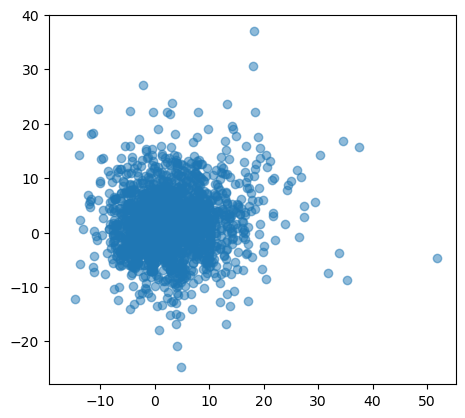

In [151]:
n_components = 2 # select number of components
mds = MDS(n_components=n_components, # initialize MDS
          dissimilarity="precomputed", # we have precomputed the distance matrix
          normalized_stress='auto',
          random_state=5 # select random state for reproducibility
         )
X = dist_arr # select distance array to analyze
MDS_scores = mds.fit_transform(X) # get MDS scores

plt.scatter(MDS_scores[:,0], MDS_scores[:,1], alpha=0.5) # plot
plt.gca().set_aspect("equal")


# Plot MDS with aspect ratio and solidity

In [173]:
MDS_df = pd.DataFrame({"dataset":dataset,
              "solidity":np.array(solidity)**8,
              "lw_ratio":1/np.array(lw_ratio),
              "MDS1":MDS_scores[:,0],
              "MDS2":MDS_scores[:,1]})

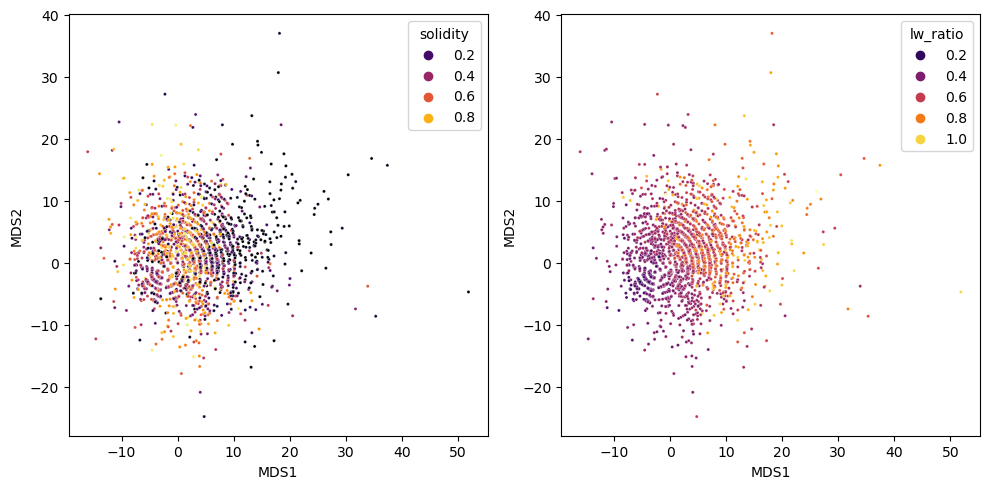

In [179]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.scatterplot(data=MDS_df,x="MDS1",y="MDS2",s=5,hue="solidity", palette="inferno")

plt.subplot(1,2,2)
sns.scatterplot(data=MDS_df,x="MDS1",y="MDS2",s=5,hue="lw_ratio", palette="inferno")

plt.tight_layout()